In [ ]:
import os
import copy
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
df_features = pd.read_csv("data/merged_features.csv", index_col=0, parse_dates=True)


In [5]:
PROJECT_DIR = Path.cwd()
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
OUT_DIR = os.path.join(PROJECT_DIR, 'output')
for d in [DATA_DIR, OUT_DIR]:
    os.makedirs(d, exist_ok=True)

In [7]:

print(f"Is GPU available? {torch.cuda.is_available()}")
print(f"Device Name: {torch.cuda.get_device_name(0)}")

Is GPU available? True
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [8]:
if torch.cuda.is_available():
    print("SUCCESS: You have an NVIDIA GPU (Best Speed)")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("SUCCESS: You have a Mac M1/M2/M3 (Good Speed)")
    device = torch.device("mps")
else:
    print("WARNING: You are using CPU (Slowest)")
    device = torch.device("cpu")

SUCCESS: You have an NVIDIA GPU (Best Speed)


In [ ]:
# ==========================================
# LSTM PIPELINE WITH LOOKBACK AS HYPERPARAM
# ==========================================
def run_lstm_sliding_window(
    df,
    target_col="Target_Log_RV",
    initial_train_size=2000,
    test_window_size=20,
    lookback_grid=(5, 10, 20, 30),
):
    """
    Rolling-window LSTM forecaster for log realised volatility with
    sequence length (lookback) included in Phase 1 hyperparameter search.


    """

    # Copy df and ensure datetime index
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # --------------------------
    # DEVICE
    # --------------------------
    device = torch.device(
        "cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using device: {device}")

    # ==========================================
    # STEP 1: SEQUENCE CREATION & PREPROCESSING
    # ==========================================
    def create_sequences(X_data, y_data, lookback):
        """
        Turn (T, F) arrays into (T-lookback, lookback, F) sequences and aligned targets.
        """
        X_seq, y_seq = [], []
        for i in range(lookback, len(X_data)):
            X_seq.append(X_data[i - lookback:i])
            y_seq.append(y_data[i])
        return np.array(X_seq), np.array(y_seq)

    def process_data_window(df_train, df_test, lookback):
        """
        For a given train/test split:
          - drop target from X
          - winsorize + standardize X on train only
          - standardize y on train only
          - build LSTM sequences for train and test
          - for test: keep only last n_test sequences so targets lie in test set
        Returns tensors on the correct device + scaler_y for inverse transform.
        """
        # Drop target from features
        cols_to_drop = [target_col]
        existing_drop_cols = [c for c in cols_to_drop if c in df_train.columns]

        X_train_raw = df_train.drop(columns=existing_drop_cols)
        y_train_raw = df_train[target_col]

        X_test_raw = df_test.drop(columns=existing_drop_cols)
        y_test_raw = df_test[target_col]

        # Winsorize (train only)
        lower = X_train_raw.quantile(0.005)
        upper = X_train_raw.quantile(0.995)
        X_train_clipped = X_train_raw.clip(lower=lower, upper=upper, axis=1)
        X_test_clipped = X_test_raw.clip(lower=lower, upper=upper, axis=1)

        # Standardize X (fit on train)
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train_clipped)
        X_test_scaled = scaler_X.transform(X_test_clipped)

        # Standardize y (fit on train)
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test_raw.values.reshape(-1, 1))

        # ---- TRAIN SEQUENCES ----
        X_train_3d, y_train_3d = create_sequences(X_train_scaled, y_train_scaled, lookback)

        # ---- TEST SEQUENCES (last n_test only) ----
        n_test = len(df_test)

        # Overlap last lookback train obs + full test to build sequences
        combined_X = np.vstack((X_train_scaled[-lookback:], X_test_scaled))
        combined_y = np.vstack((y_train_scaled[-lookback:], y_test_scaled))

        X_test_3d_all, y_test_3d_all = create_sequences(combined_X, combined_y, lookback)

        # Keep only sequences whose targets lie in the test set
        X_test_3d = X_test_3d_all[-n_test:]
        y_test_3d = y_test_3d_all[-n_test:]

        # To torch
        X_train_t = torch.tensor(X_train_3d, dtype=torch.float32).to(device)
        y_train_t = torch.tensor(y_train_3d, dtype=torch.float32).to(device)
        X_test_t = torch.tensor(X_test_3d, dtype=torch.float32).to(device)

        return X_train_t, y_train_t, X_test_t, y_test_3d, scaler_y

    # ==========================================
    # STEP 2: MODEL CLASS
    # ==========================================
    class VolatilityLSTM(nn.Module):
        def __init__(self, n_features, n_layers, units, dropout):
            super(VolatilityLSTM, self).__init__()

            self.lstm = nn.LSTM(
                input_size=n_features,
                hidden_size=units,
                num_layers=n_layers,
                batch_first=True,
                dropout=dropout if n_layers > 1 else 0.0
            )

            self.fc = nn.Linear(units, 1)
            self.dropout_layer = nn.Dropout(dropout)

        def forward(self, x):
            # x: (batch, seq_len, features)
            out, _ = self.lstm(x)
            # take last time step
            last_step = out[:, -1, :]
            last_step = self.dropout_layer(last_step)
            prediction = self.fc(last_step)
            return prediction

    # ==========================================
    # STEP 3: TRAINING & EVALUATION HELPER
    # ==========================================
    def train_and_evaluate(params, X_train, y_train, validation_split=0.2, epochs=50):
        """
        Train LSTM with given params on X_train/y_train, using
        a chronological validation split and early stopping.
        Returns best validation loss and best model state_dict.
        """
        # Chronological split
        split_idx = int(len(X_train) * (1 - validation_split))
        X_t, y_t = X_train[:split_idx], y_train[:split_idx]
        X_v, y_v = X_train[split_idx:], y_train[split_idx:]

        n_features = X_train.shape[2]

        model = VolatilityLSTM(
            n_features=n_features,
            n_layers=params['num_layers'],
            units=params['units'],
            dropout=params['dropout']
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        patience_limit = 10

        for epoch in range(epochs):
            # ---- TRAIN ----
            model.train()
            optimizer.zero_grad()
            output = model(X_t)
            loss = criterion(output, y_t)
            loss.backward()
            optimizer.step()

            # ---- VALIDATION ----
            model.eval()
            with torch.no_grad():
                val_out = model(X_v)
                val_loss = criterion(val_out, y_v).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience_limit:
                break

        return best_val_loss, best_model_state

    # ==========================================
    # STEP 4: PHASE 1 GLOBAL SEARCH (INCL. LOOKBACK)
    # ==========================================
    print("\n=== PHASE 1: GLOBAL SEARCH (INCL. LOOKBACK) ===")

    # Use first initial_train_size obs
    df_phase1 = df.iloc[:initial_train_size]

    param_grid = {
        'lookback': list(lookback_grid),
        'num_layers': [1, 2],
        'units': [16, 32, 64],
        'dropout': [0.1, 0.2, 0.3,0.4,0.5],
        'learning_rate': [1e-1,1e-2,1e-3, 1e-4,1e-5]
    }

    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_global_loss = float('inf')
    best_global_params = None

    print(f"Testing {len(combinations)} combinations...")

    for i, params in enumerate(combinations):
        lookback = params['lookback']

        # Build train sequences for this lookback
        # Dummy "test" just to satisfy function signature; last lookback rows
        X_train_p1, y_train_p1, _, _, _ = process_data_window(
            df_phase1,
            df_phase1.iloc[-lookback:],
            lookback
        )

        val_loss, _ = train_and_evaluate(params, X_train_p1, y_train_p1, epochs=50)

        if val_loss < best_global_loss:
            best_global_loss = val_loss
            best_global_params = params
            print(f"New Best [{i}]: {params} | Val Loss: {val_loss:.5f}")

 
    print(f"Best Structure (incl. lookback): {best_global_params}")

     # ==========================================
    # STEP 5: PHASE 2 ROLLING WALK-FORWARD (SLIDING WINDOW)
    # ==========================================

    predictions = []
    actuals = []
    prediction_dates = []
    train_r2_list = []
    val_r2_list = []
    test_r2_list = []
    window_end_dates = []

    window_size = initial_train_size   # fixed rolling window length
    current_idx = initial_train_size   # first window ends here

    best_lookback = best_global_params['lookback']

    while current_idx < len(df):
        test_end_idx = min(current_idx + test_window_size, len(df))
        if test_end_idx <= current_idx:
            break

        # SLIDING WINDOW: use only the last `window_size` observations
        train_start_idx = current_idx - window_size
        df_train_curr = df.iloc[train_start_idx:current_idx]
        df_test_curr  = df.iloc[current_idx:test_end_idx]
        current_test_dates = df_test_curr.index

        print(f"\nWindow: Train[{train_start_idx}:{current_idx}] → Test[{current_idx}:{test_end_idx}]")

        # Process window with best global lookback
        X_train_t, y_train_t, X_test_t, y_test_3d, scaler_y = process_data_window(
            df_train_curr, df_test_curr, best_lookback
        )

        # Refinement grid: keep structure + lookback, tune dropout + LR
        refine_grid = {
            'num_layers':   [best_global_params['num_layers']],
            'units':        [best_global_params['units']],
            'dropout':      [0.1, 0.2, 0.3, 0.4,0.5],
            'learning_rate':[best_global_params['learning_rate']]
        }

        r_keys, r_values = zip(*refine_grid.items())
        r_combos = [dict(zip(r_keys, v)) for v in itertools.product(*r_values)]

        best_local_loss = float('inf')
        best_local_model_state = None
        best_local_params = None

        # Grid search on this window
        for params in r_combos:
            val_loss, state = train_and_evaluate(
                params,
                X_train_t,
                y_train_t,
                validation_split=0.2,
                epochs=50
            )
            if val_loss < best_local_loss:
                best_local_loss = val_loss
                best_local_model_state = state
                best_local_params = params

        # Instantiate final model with best global structure (dropout irrelevant in eval mode)
        n_features = X_train_t.shape[2]
        final_model = VolatilityLSTM(
            n_features,
            best_global_params['num_layers'],
            best_global_params['units'],
            dropout=0.0
        ).to(device)

        final_model.load_state_dict(best_local_model_state)
        final_model.eval()

        # --- R² TRAIN / VAL (current window, on standardised log-vol) ---
        split_idx = int(len(X_train_t) * (1 - 0.1))
        X_tr, y_tr = X_train_t[:split_idx], y_train_t[:split_idx]
        X_val, y_val = X_train_t[split_idx:], y_train_t[split_idx:]

        with torch.no_grad():
            train_pred_scaled = final_model(X_tr).cpu().numpy().flatten()
            train_true_scaled = y_tr.cpu().numpy().flatten()

            val_pred_scaled = final_model(X_val).cpu().numpy().flatten()
            val_true_scaled = y_val.cpu().numpy().flatten()

        train_r2 = r2_score(train_true_scaled, train_pred_scaled)
        val_r2 = r2_score(val_true_scaled, val_pred_scaled)

        # --- TEST R² + STORE PREDICTIONS ---
        with torch.no_grad():
            pred_scaled_t = final_model(X_test_t)
            pred_scaled = pred_scaled_t.cpu().numpy()

        pred_real   = scaler_y.inverse_transform(pred_scaled)
        actual_real = scaler_y.inverse_transform(y_test_3d)

        test_r2 = r2_score(actual_real.flatten(), pred_real.flatten())

        predictions.extend(pred_real.flatten())
        actuals.extend(actual_real.flatten())
        prediction_dates.extend(current_test_dates)

        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
        test_r2_list.append(test_r2)
        window_end_dates.append(current_test_dates[-1])

        current_idx += test_window_size


    # ==========================================
    # STEP 6: GLOBAL METRICS ON VOL LEVEL
    # ==========================================
    pred_log = np.array(predictions)
    actual_log = np.array(actuals)

    pred_vol = np.exp(pred_log)
    actual_vol = np.exp(actual_log)

    # RMSE / MAE on raw realised volatility
    rmse = np.sqrt(mean_squared_error(actual_vol, pred_vol))
    mae = np.mean(np.abs(actual_vol - pred_vol))

    # R² vs mean (on vol)
    ss_res = np.sum((actual_vol - pred_vol) ** 2)
    ss_tot = np.sum((actual_vol - actual_vol.mean()) ** 2)
    r2_mean = 1 - ss_res / ss_tot

    # R² vs random walk (on vol)
    y_true = actual_vol
    y_pred = pred_vol
    y_lag = y_true[:-1]
    y_now = y_true[1:]
    y_pred_now = y_pred[1:]

    num = np.sum((y_now - y_pred_now) ** 2)
    den = np.sum((y_now - y_lag) ** 2)
    r2_rw = 1 - num / den

    print("\n================ LSTM FINAL PERFORMANCE (RAW VOL) ================")
    print(f"RMSE (Raw Realized Vol): {rmse:.6f}")
    print(f"MAE  (Raw Realized Vol): {mae:.6f}")
    print(f"R2 (vs mean, LSTM):      {r2_mean:.6f}")
    print(f"R2 (vs RW, LSTM):        {r2_rw:.6f}")
    print("===================================================================")
    print(f"Total Predictions: {len(predictions)}")
    print(f"Date Range: {prediction_dates[0].date()} to {prediction_dates[-1].date()}")

    # ==========================================
    # STEP 7: R² PER WINDOW + RESULTS DF
    # ==========================================
    r2_windows_df = pd.DataFrame({
        "Train_R2": train_r2_list,
        "Val_R2":   val_r2_list,
        "Test_R2":  test_r2_list
    }, index=pd.to_datetime(window_end_dates))

    results_lstm = pd.DataFrame({
        "Pred_Log": pred_log,
        "True_Log": actual_log
    }, index=pd.to_datetime(prediction_dates))

    results_lstm["Pred_Vol"] = np.exp(results_lstm["Pred_Log"])
    results_lstm["True_Vol"] = np.exp(results_lstm["True_Log"])

    # ==========================================
    # STEP 8: PLOT REALISED VS LSTM FORECAST
    # ==========================================
    plt.figure(figsize=(15, 6))
    plt.plot(results_lstm.index, results_lstm["True_Vol"]*100,
             color="silver", alpha=1, linewidth=0.9, label="Realised Daily Volatility")
    plt.plot(results_lstm.index, results_lstm["Pred_Vol"]*100,
             color="firebrick", alpha=0.8, linewidth=0.9, label="LSTM Forecast")
    
    plt.title("LSTM Predictions vs Realised Daily Volatility", fontsize=12, fontweight="bold")
    plt.ylabel("Daily Volatility (%)")
    plt.xlabel("Date")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()

    try:
        save_path = os.path.join(OUT_DIR, 'lstm_forecast_results.pdf')
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Graph saved to: {save_path}")
    except NameError:
        print("Could not save PDF (OUT_DIR not defined).")

    plt.show()

    # ==========================================
    # STEP 9: METRICS DICT
    # ==========================================
    metrics_lstm = {
        "RMSE": rmse,
        "MAE": mae,
        "R2_mean": r2_mean,
        "R2_RW": r2_rw,
        "R2_windows": r2_windows_df,
        "Best_Global_Params": best_global_params
    }

    return results_lstm, metrics_lstm


Using device: cuda

=== PHASE 1: GLOBAL SEARCH (INCL. LOOKBACK) ===
Testing 600 combinations...
New Best [0]: {'lookback': 5, 'num_layers': 1, 'units': 16, 'dropout': 0.1, 'learning_rate': 0.1} | Val Loss: 1.11787
New Best [1]: {'lookback': 5, 'num_layers': 1, 'units': 16, 'dropout': 0.1, 'learning_rate': 0.01} | Val Loss: 0.65252
New Best [11]: {'lookback': 5, 'num_layers': 1, 'units': 16, 'dropout': 0.3, 'learning_rate': 0.01} | Val Loss: 0.62360
New Best [20]: {'lookback': 5, 'num_layers': 1, 'units': 16, 'dropout': 0.5, 'learning_rate': 0.1} | Val Loss: 0.61264
New Best [30]: {'lookback': 5, 'num_layers': 1, 'units': 32, 'dropout': 0.2, 'learning_rate': 0.1} | Val Loss: 0.57106
New Best [40]: {'lookback': 5, 'num_layers': 1, 'units': 32, 'dropout': 0.4, 'learning_rate': 0.1} | Val Loss: 0.56499
New Best [45]: {'lookback': 5, 'num_layers': 1, 'units': 32, 'dropout': 0.5, 'learning_rate': 0.1} | Val Loss: 0.56368
New Best [46]: {'lookback': 5, 'num_layers': 1, 'units': 32, 'dropout':

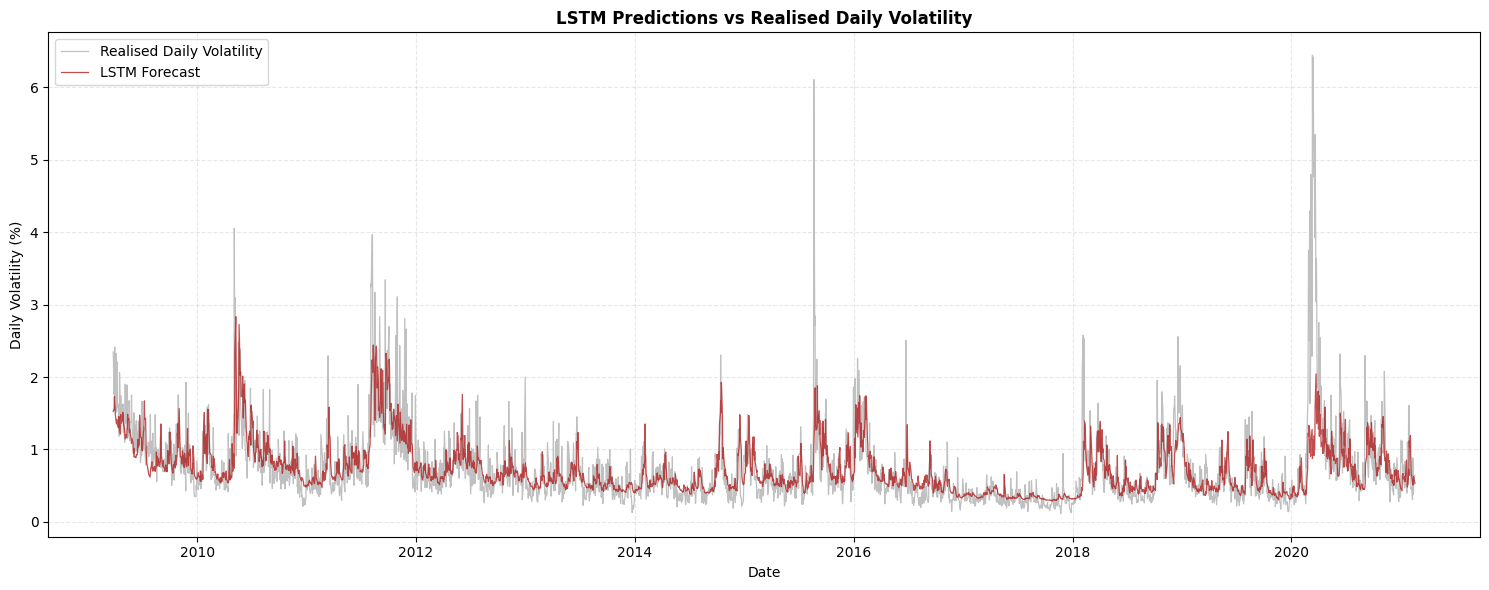

In [33]:
results_lstm_2, metrics_lstm_2 = run_lstm_sliding_window(df_features)

In [46]:
#download the result as csv file:
results_lstm_2.to_csv("results_lstm.csv")



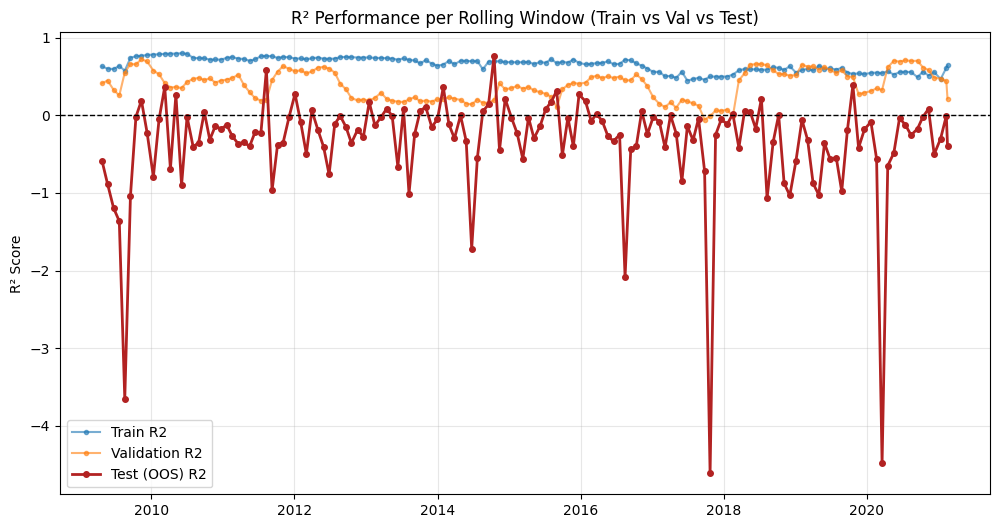

In [34]:
# Assuming 'results_lstm' and 'metrics_lstm' are returned from your function run_lstm_sliding_window(...)

r2_df = metrics_lstm_2["R2_windows"]

plt.figure(figsize=(12, 6))
plt.plot(r2_df.index, r2_df['Train_R2'], label='Train R2', marker='o', markersize=3, alpha=0.6)
plt.plot(r2_df.index, r2_df['Val_R2'], label='Validation R2', marker='o', markersize=3, alpha=0.6)
plt.plot(r2_df.index, r2_df['Test_R2'], label='Test (OOS) R2', marker='o', markersize=4, linewidth=2, color='firebrick')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("R² Performance per Rolling Window (Train vs Val vs Test)")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

We keep this results to ensure comparability accrosse models even if results are not as good as expected, probably due to the short train / val windows

Keep our selected LSTM architecture and apply EGARCH features:

In [3]:
df_all_features = pd.read_csv('data/EGARCH_all_features.csv', index_col=0, parse_dates=True)

In [ ]:
# ==========================================
# LSTM PIPELINE WITH LOOKBACK AS HYPERPARAM
# ==========================================
def run_lstm_sliding_window(
    df,
    target_col="Target_Log_RV",
    initial_train_size=2000,
    test_window_size=20,
    lookback_grid=(5, 10, 20, 30),
):
    """
    Rolling-window LSTM forecaster for log realised volatility with
    sequence length (lookback) included in Phase 1 hyperparameter search.

   
    """

    # Copy df and ensure datetime index
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # --------------------------
    # DEVICE
    # --------------------------
    device = torch.device(
        "cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using device: {device}")

    # ==========================================
    # STEP 1: SEQUENCE CREATION & PREPROCESSING
    # ==========================================
    def create_sequences(X_data, y_data, lookback):
        """
        Turn (T, F) arrays into (T-lookback, lookback, F) sequences and aligned targets.
        """
        X_seq, y_seq = [], []
        for i in range(lookback, len(X_data)):
            X_seq.append(X_data[i - lookback:i])
            y_seq.append(y_data[i])
        return np.array(X_seq), np.array(y_seq)

    def process_data_window(df_train, df_test, lookback):
        """
        For a given train/test split:
          - drop target from X
          - winsorize + standardize X on train only
          - standardize y on train only
          - build LSTM sequences for train and test
          - for test: keep only last n_test sequences so targets lie in test set
        Returns tensors on the correct device + scaler_y for inverse transform.
        """
        # Drop target from features
        cols_to_drop = [target_col]
        existing_drop_cols = [c for c in cols_to_drop if c in df_train.columns]

        X_train_raw = df_train.drop(columns=existing_drop_cols)
        y_train_raw = df_train[target_col]

        X_test_raw = df_test.drop(columns=existing_drop_cols)
        y_test_raw = df_test[target_col]

        # Winsorize (train only)
        lower = X_train_raw.quantile(0.005)
        upper = X_train_raw.quantile(0.995)
        X_train_clipped = X_train_raw.clip(lower=lower, upper=upper, axis=1)
        X_test_clipped = X_test_raw.clip(lower=lower, upper=upper, axis=1)

        # Standardize X (fit on train)
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train_clipped)
        X_test_scaled = scaler_X.transform(X_test_clipped)

        # Standardize y (fit on train)
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test_raw.values.reshape(-1, 1))

        # ---- TRAIN SEQUENCES ----
        X_train_3d, y_train_3d = create_sequences(X_train_scaled, y_train_scaled, lookback)

        # ---- TEST SEQUENCES (last n_test only) ----
        n_test = len(df_test)

        # Overlap last lookback train obs + full test to build sequences
        combined_X = np.vstack((X_train_scaled[-lookback:], X_test_scaled))
        combined_y = np.vstack((y_train_scaled[-lookback:], y_test_scaled))

        X_test_3d_all, y_test_3d_all = create_sequences(combined_X, combined_y, lookback)

        # Keep only sequences whose targets lie in the test set
        X_test_3d = X_test_3d_all[-n_test:]
        y_test_3d = y_test_3d_all[-n_test:]

        # To torch
        X_train_t = torch.tensor(X_train_3d, dtype=torch.float32).to(device)
        y_train_t = torch.tensor(y_train_3d, dtype=torch.float32).to(device)
        X_test_t = torch.tensor(X_test_3d, dtype=torch.float32).to(device)

        return X_train_t, y_train_t, X_test_t, y_test_3d, scaler_y

    # ==========================================
    # STEP 2: MODEL CLASS
    # ==========================================
    class VolatilityLSTM(nn.Module):
        def __init__(self, n_features, n_layers, units, dropout):
            super(VolatilityLSTM, self).__init__()

            self.lstm = nn.LSTM(
                input_size=n_features,
                hidden_size=units,
                num_layers=n_layers,
                batch_first=True,
                dropout=dropout if n_layers > 1 else 0.0
            )

            self.fc = nn.Linear(units, 1)
            self.dropout_layer = nn.Dropout(dropout)

        def forward(self, x):
            # x: (batch, seq_len, features)
            out, _ = self.lstm(x)
            # take last time step
            last_step = out[:, -1, :]
            last_step = self.dropout_layer(last_step)
            prediction = self.fc(last_step)
            return prediction

    # ==========================================
    # STEP 3: TRAINING & EVALUATION HELPER
    # ==========================================
    def train_and_evaluate(params, X_train, y_train, validation_split=0.2, epochs=50):
        """
        Train LSTM with given params on X_train/y_train, using
        a chronological validation split and early stopping.
        Returns best validation loss and best model state_dict.
        """
        # Chronological split
        split_idx = int(len(X_train) * (1 - validation_split))
        X_t, y_t = X_train[:split_idx], y_train[:split_idx]
        X_v, y_v = X_train[split_idx:], y_train[split_idx:]

        n_features = X_train.shape[2]

        model = VolatilityLSTM(
            n_features=n_features,
            n_layers=params['num_layers'],
            units=params['units'],
            dropout=params['dropout']
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        patience_limit = 10

        for epoch in range(epochs):
            # ---- TRAIN ----
            model.train()
            optimizer.zero_grad()
            output = model(X_t)
            loss = criterion(output, y_t)
            loss.backward()
            optimizer.step()

            # ---- VALIDATION ----
            model.eval()
            with torch.no_grad():
                val_out = model(X_v)
                val_loss = criterion(val_out, y_v).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience_limit:
                break

        return best_val_loss, best_model_state

    # ==========================================
    # STEP 4: PHASE 1 GLOBAL SEARCH (INCL. LOOKBACK)
    # ==========================================
    print("\n=== PHASE 1: GLOBAL SEARCH (INCL. LOOKBACK) ===")

    # Use first initial_train_size obs
    df_phase1 = df.iloc[:initial_train_size]

    param_grid = {
        'lookback': list(lookback_grid),
        'num_layers': [1, 2],
        'units': [16, 32, 64],
        'dropout': [0.1, 0.2, 0.3,0.4,0.5],
        'learning_rate': [1e-1,1e-2,1e-3, 1e-4,1e-5]
    }

    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_global_loss = float('inf')
    best_global_params = None

    print(f"Testing {len(combinations)} combinations...")

    for i, params in enumerate(combinations):
        lookback = params['lookback']

        # Build train sequences for this lookback
        # Dummy "test" just to satisfy function signature; last lookback rows
        X_train_p1, y_train_p1, _, _, _ = process_data_window(
            df_phase1,
            df_phase1.iloc[-lookback:],
            lookback
        )

        val_loss, _ = train_and_evaluate(params, X_train_p1, y_train_p1, epochs=50)

        if val_loss < best_global_loss:
            best_global_loss = val_loss
            best_global_params = params
            print(f"New Best [{i}]: {params} | Val Loss: {val_loss:.5f}")

 
    print(f"Best Structure (incl. lookback): {best_global_params}")

     # ==========================================
    # STEP 5: PHASE 2 ROLLING WALK-FORWARD (SLIDING WINDOW)
    # ==========================================

    predictions = []
    actuals = []
    prediction_dates = []
    train_r2_list = []
    val_r2_list = []
    test_r2_list = []
    window_end_dates = []

    window_size = initial_train_size   # fixed rolling window length
    current_idx = initial_train_size   # first window ends here

    best_lookback = best_global_params['lookback']

    while current_idx < len(df):
        test_end_idx = min(current_idx + test_window_size, len(df))
        if test_end_idx <= current_idx:
            break

        # SLIDING WINDOW: use only the last `window_size` observations
        train_start_idx = current_idx - window_size
        df_train_curr = df.iloc[train_start_idx:current_idx]
        df_test_curr  = df.iloc[current_idx:test_end_idx]
        current_test_dates = df_test_curr.index

        print(f"\nWindow: Train[{train_start_idx}:{current_idx}] → Test[{current_idx}:{test_end_idx}]")

        # Process window with best global lookback
        X_train_t, y_train_t, X_test_t, y_test_3d, scaler_y = process_data_window(
            df_train_curr, df_test_curr, best_lookback
        )

        # Refinement grid: keep structure + lookback, tune dropout + LR
        refine_grid = {
            'num_layers':   [best_global_params['num_layers']],
            'units':        [best_global_params['units']],
            'dropout':      [0.1, 0.2, 0.3, 0.4,0.5],
            'learning_rate':[best_global_params['learning_rate']]
        }

        r_keys, r_values = zip(*refine_grid.items())
        r_combos = [dict(zip(r_keys, v)) for v in itertools.product(*r_values)]

        best_local_loss = float('inf')
        best_local_model_state = None
        best_local_params = None

        # Grid search on this window
        for params in r_combos:
            val_loss, state = train_and_evaluate(
                params,
                X_train_t,
                y_train_t,
                validation_split=0.2,
                epochs=50
            )
            if val_loss < best_local_loss:
                best_local_loss = val_loss
                best_local_model_state = state
                best_local_params = params

        # Instantiate final model with best global structure (dropout irrelevant in eval mode)
        n_features = X_train_t.shape[2]
        final_model = VolatilityLSTM(
            n_features,
            best_global_params['num_layers'],
            best_global_params['units'],
            dropout=0.0
        ).to(device)

        final_model.load_state_dict(best_local_model_state)
        final_model.eval()

        # --- R² TRAIN / VAL (current window, on standardised log-vol) ---
        split_idx = int(len(X_train_t) * (1 - 0.1))
        X_tr, y_tr = X_train_t[:split_idx], y_train_t[:split_idx]
        X_val, y_val = X_train_t[split_idx:], y_train_t[split_idx:]

        with torch.no_grad():
            train_pred_scaled = final_model(X_tr).cpu().numpy().flatten()
            train_true_scaled = y_tr.cpu().numpy().flatten()

            val_pred_scaled = final_model(X_val).cpu().numpy().flatten()
            val_true_scaled = y_val.cpu().numpy().flatten()

        train_r2 = r2_score(train_true_scaled, train_pred_scaled)
        val_r2 = r2_score(val_true_scaled, val_pred_scaled)

        # --- TEST R² + STORE PREDICTIONS ---
        with torch.no_grad():
            pred_scaled_t = final_model(X_test_t)
            pred_scaled = pred_scaled_t.cpu().numpy()

        pred_real   = scaler_y.inverse_transform(pred_scaled)
        actual_real = scaler_y.inverse_transform(y_test_3d)

        test_r2 = r2_score(actual_real.flatten(), pred_real.flatten())

        predictions.extend(pred_real.flatten())
        actuals.extend(actual_real.flatten())
        prediction_dates.extend(current_test_dates)

        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
        test_r2_list.append(test_r2)
        window_end_dates.append(current_test_dates[-1])

        current_idx += test_window_size


    # ==========================================
    # STEP 6: GLOBAL METRICS ON VOL LEVEL
    # ==========================================
    pred_log = np.array(predictions)
    actual_log = np.array(actuals)

    pred_vol = np.exp(pred_log)
    actual_vol = np.exp(actual_log)

    # RMSE / MAE on raw realised volatility
    rmse = np.sqrt(mean_squared_error(actual_vol, pred_vol))
    mae = np.mean(np.abs(actual_vol - pred_vol))

    # R² vs mean (on vol)
    ss_res = np.sum((actual_vol - pred_vol) ** 2)
    ss_tot = np.sum((actual_vol - actual_vol.mean()) ** 2)
    r2_mean = 1 - ss_res / ss_tot

    # R² vs random walk (on vol)
    y_true = actual_vol
    y_pred = pred_vol
    y_lag = y_true[:-1]
    y_now = y_true[1:]
    y_pred_now = y_pred[1:]

    num = np.sum((y_now - y_pred_now) ** 2)
    den = np.sum((y_now - y_lag) ** 2)
    r2_rw = 1 - num / den

    print("\n================ LSTM FINAL PERFORMANCE (RAW VOL) ================")
    print(f"RMSE (Raw Realized Vol): {rmse:.6f}")
    print(f"MAE  (Raw Realized Vol): {mae:.6f}")
    print(f"R2 (vs mean, LSTM):      {r2_mean:.6f}")
    print(f"R2 (vs RW, LSTM):        {r2_rw:.6f}")
    print("===================================================================")
    print(f"Total Predictions: {len(predictions)}")
    print(f"Date Range: {prediction_dates[0].date()} to {prediction_dates[-1].date()}")

    # ==========================================
    # STEP 7: R² PER WINDOW + RESULTS DF
    # ==========================================
    r2_windows_df = pd.DataFrame({
        "Train_R2": train_r2_list,
        "Val_R2":   val_r2_list,
        "Test_R2":  test_r2_list
    }, index=pd.to_datetime(window_end_dates))

    results_lstm = pd.DataFrame({
        "Pred_Log": pred_log,
        "True_Log": actual_log
    }, index=pd.to_datetime(prediction_dates))

    results_lstm["Pred_Vol"] = np.exp(results_lstm["Pred_Log"])
    results_lstm["True_Vol"] = np.exp(results_lstm["True_Log"])

    # ==========================================
    # STEP 8: PLOT REALISED VS LSTM FORECAST
    # ==========================================
    plt.figure(figsize=(15, 6))
    plt.plot(results_lstm.index, results_lstm["True_Vol"]*100,
             color="silver", alpha=1, linewidth=0.9, label="Realised Daily Volatility")
    plt.plot(results_lstm.index, results_lstm["Pred_Vol"]*100,
             color="firebrick", alpha=0.8, linewidth=0.9, label="LSTM Forecast")
    
    plt.title("LSTM Predictions vs Realised Daily Volatility", fontsize=12, fontweight="bold")
    plt.ylabel("Daily Volatility (%)")
    plt.xlabel("Date")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()

    try:
        save_path = os.path.join(OUT_DIR, 'lstm_forecast_results.pdf')
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Graph saved to: {save_path}")
    except NameError:
        print("Could not save PDF (OUT_DIR not defined).")

    plt.show()

    # ==========================================
    # STEP 9: METRICS DICT
    # ==========================================
    metrics_lstm = {
        "RMSE": rmse,
        "MAE": mae,
        "R2_mean": r2_mean,
        "R2_RW": r2_rw,
        "R2_windows": r2_windows_df,
        "Best_Global_Params": best_global_params
    }

    return results_lstm, metrics_lstm


Using device: cuda

=== PHASE 1: GLOBAL SEARCH (INCL. LOOKBACK) ===
Testing 600 combinations...
New Best [0]: {'lookback': 5, 'num_layers': 1, 'units': 16, 'dropout': 0.1, 'learning_rate': 0.1} | Val Loss: 0.60976
New Best [30]: {'lookback': 5, 'num_layers': 1, 'units': 32, 'dropout': 0.2, 'learning_rate': 0.1} | Val Loss: 0.60005
New Best [51]: {'lookback': 5, 'num_layers': 1, 'units': 64, 'dropout': 0.1, 'learning_rate': 0.01} | Val Loss: 0.52038
New Best [201]: {'lookback': 10, 'num_layers': 1, 'units': 64, 'dropout': 0.1, 'learning_rate': 0.01} | Val Loss: 0.47608
Best Structure (incl. lookback): {'lookback': 10, 'num_layers': 1, 'units': 64, 'dropout': 0.1, 'learning_rate': 0.01}

Window: Train[0:2000] → Test[2000:2020]

Window: Train[20:2020] → Test[2020:2040]

Window: Train[40:2040] → Test[2040:2060]

Window: Train[60:2060] → Test[2060:2080]

Window: Train[80:2080] → Test[2080:2100]

Window: Train[100:2100] → Test[2100:2120]

Window: Train[120:2120] → Test[2120:2140]

Window: Tr

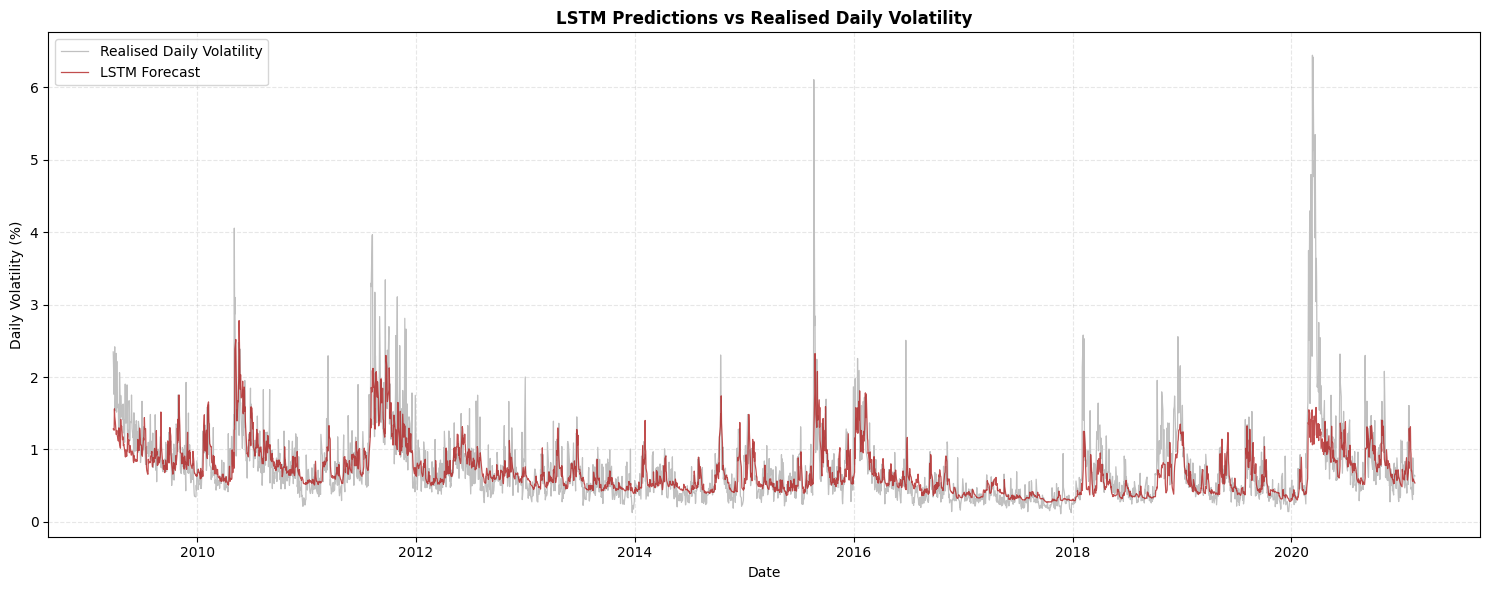

: 

In [ ]:
results_lstm_EGARCH, metrics_lstm_EGARCH = run_lstm_sliding_window(df_all_features)